In [1]:
%load_ext autoreload
import torch
from torch import nn
from torch.optim import Adam
import torchcfm
import sys

import matplotlib.pyplot as plt
from gen_model_playground.data.twomoons import TwoMoonsDataModule
import numpy as np
import os
from my_cmaps import cmap
from matplotlib.colors import LinearSegmentedColormap
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
import os

/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

In [15]:
from torch.utils.data import DataLoader, ConcatDataset
from torch import nn
sys.path.append("../")
from models.model import Disc
import torch.optim as optim
import torch.nn.functional as F
datadir="/beegfs/desy/user/kaechben/thesis/jetnet30"
# Create a list to hold all datasets
datasets = []
data_dict = {}
num_epochs=100
for i, file in enumerate(os.listdir(datadir)):
    data = torch.load(os.path.join(datadir, file))
    data_dict[file] = data

    # Assuming each data is a tensor of inputs
    inputs = data.float()
    mask =data[:,:,2]==0
    cond=(~mask).float().sum(1).unsqueeze(1).unsqueeze(1)
    labels = torch.tensor([i] * len(inputs))  # Assign a unique class to each file

    # Create a TensorDataset for each file
    dataset = torch.utils.data.TensorDataset(inputs, labels,mask,cond)
    datasets.append(dataset)

# Concatenate all datasets into one
combined_dataset = ConcatDataset(datasets)

# Create a single DataLoader
dataloader = DataLoader(combined_dataset, batch_size=1024, shuffle=True)

# Define the model
model = Disc(3,16,512,4,32,0,1,False,False,False,len(os.listdir(datadir)))
Disc.avg_n=(~mask).float().sum(1).mean()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels, mask, cond in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = F.softmax(model(inputs,mask,cond)[0]).squeeze(1)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')

print('Finished Training')

/tmp/ipykernel_29617/1830047260.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(inputs,mask,cond)[0]).squeeze(1)


KeyboardInterrupt: 

/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


Your vector field does not have `nn.Parameters` to optimize.
Your vector field does not have `nn.Parameters` to optimize.


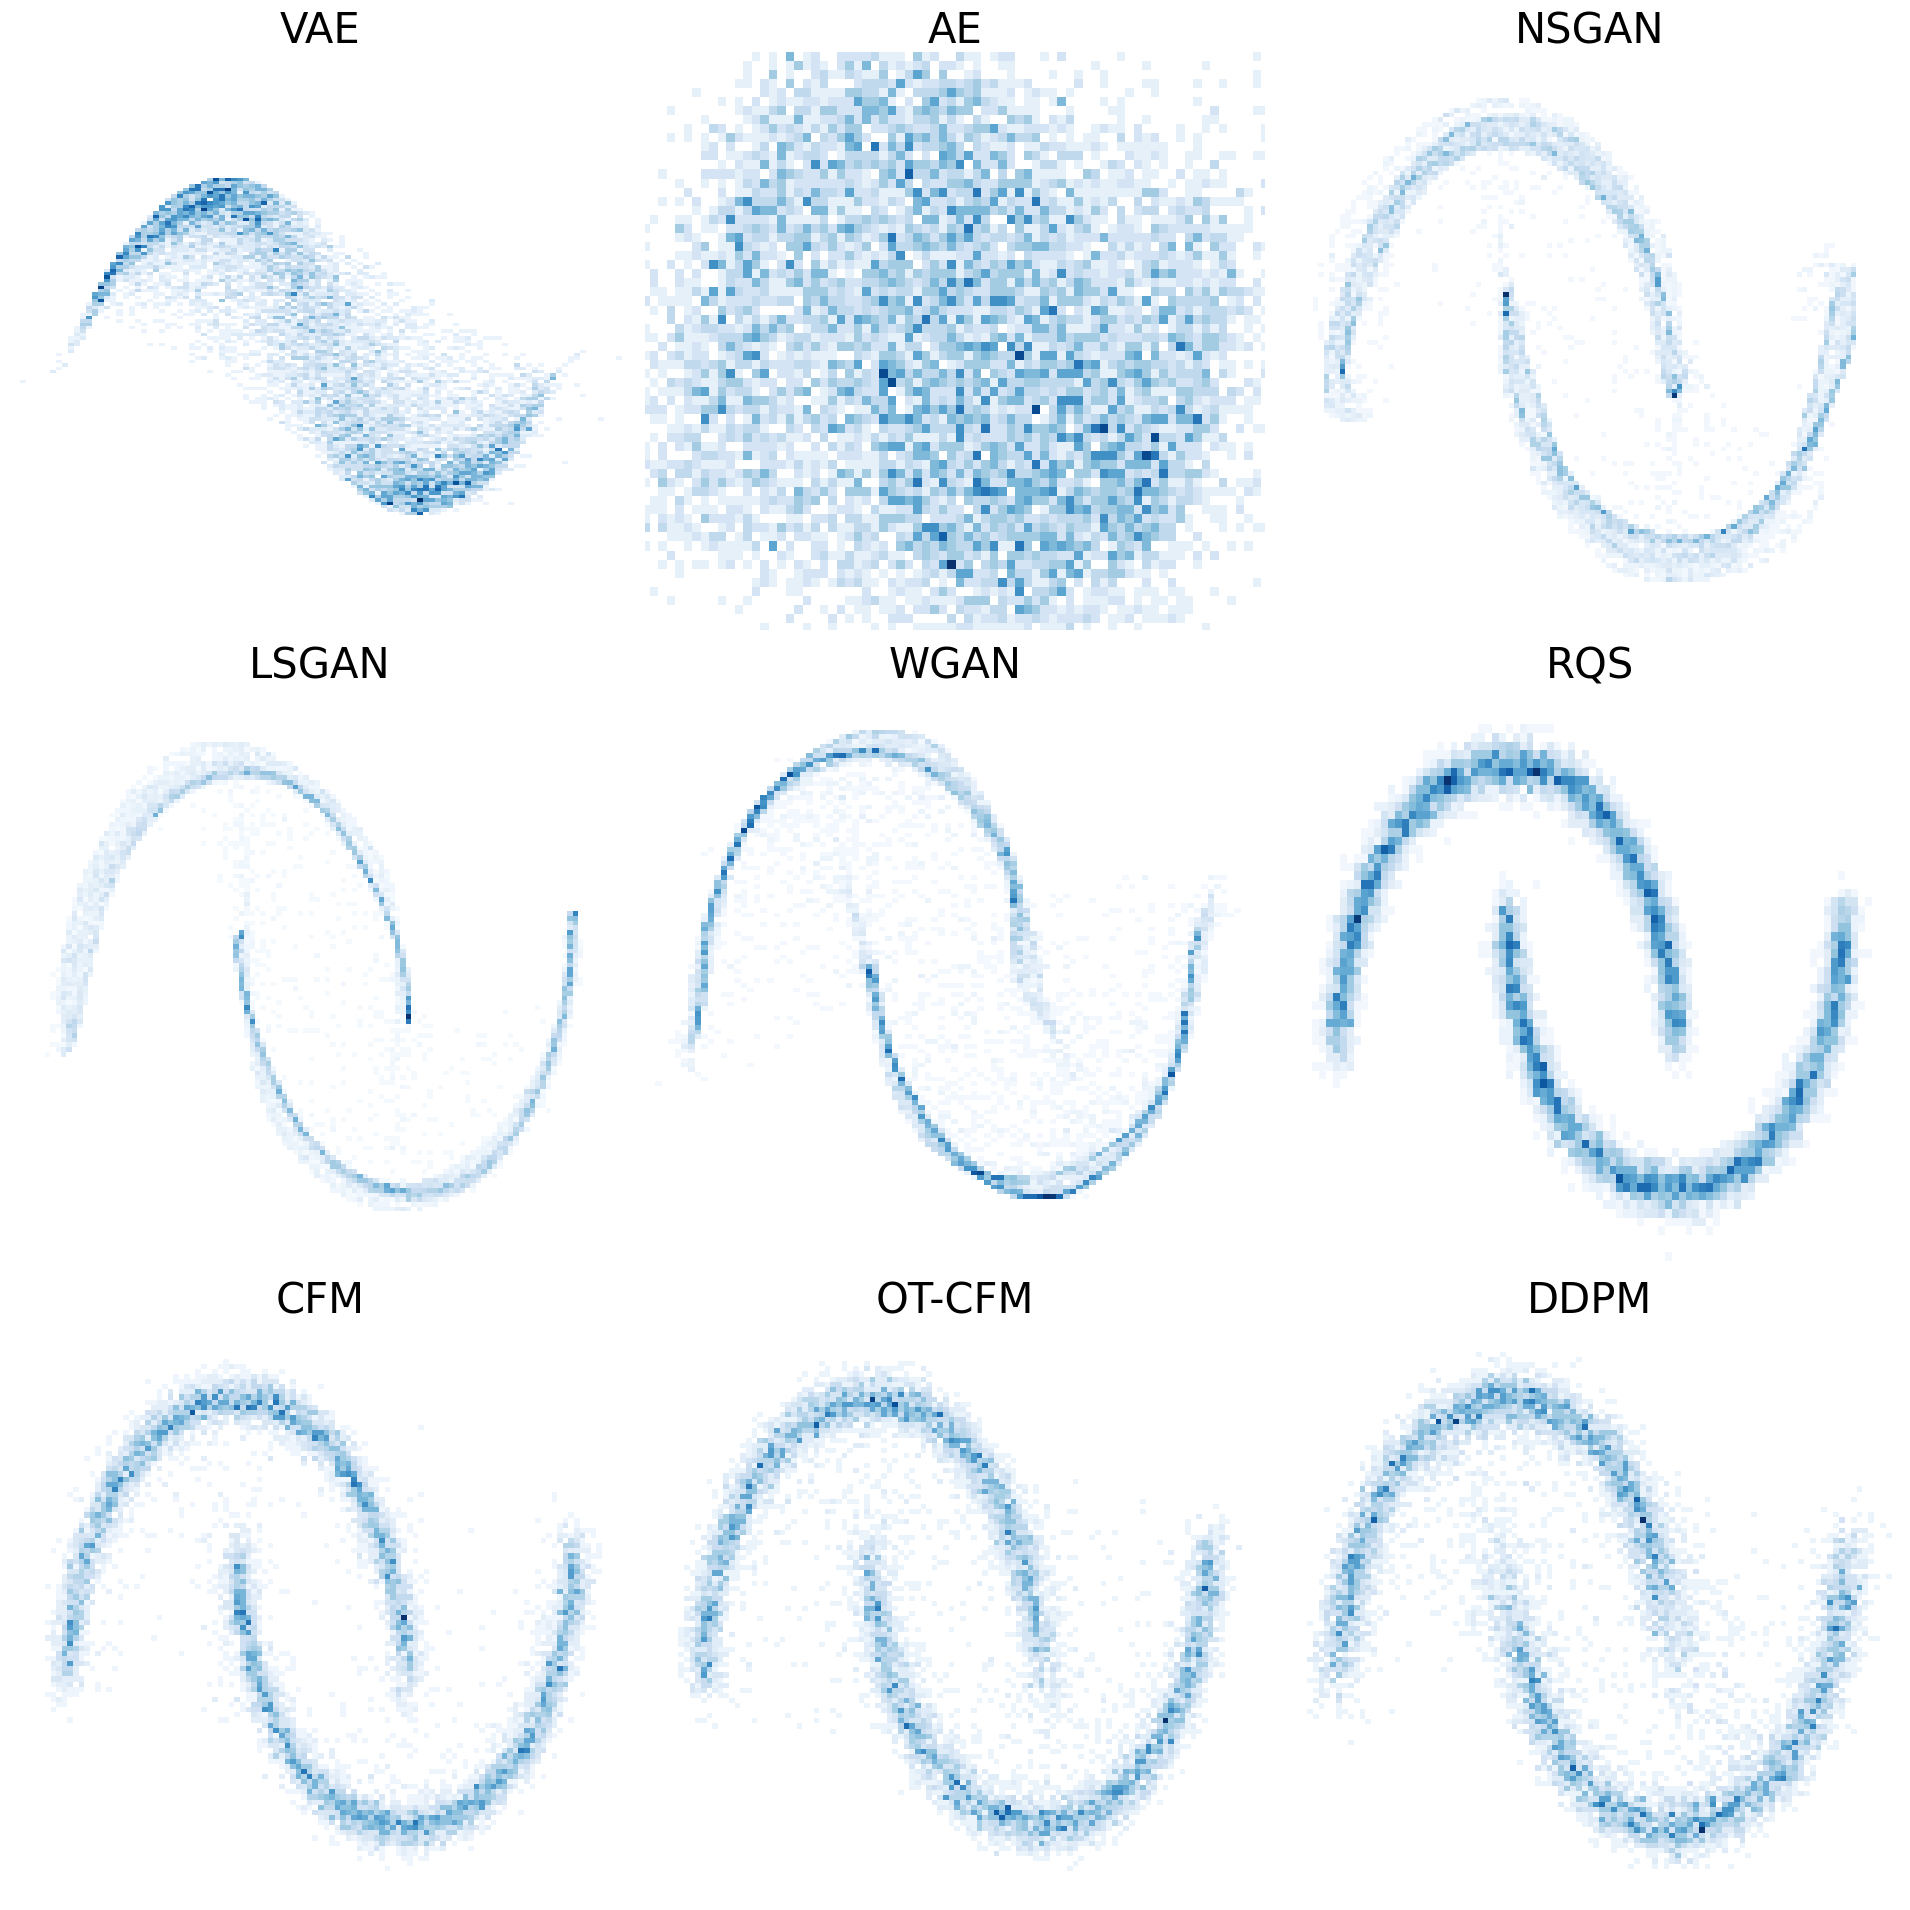

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
data_dict={}
cmap = LinearSegmentedColormap.from_list("", ["white", *plt.cm.Blues(np.arange(255))])

lims=[[ae.hparams.scaled_min[0]*1.1,ae.hparams.scaled_max[0]*1.1]
        ,[ae.hparams.scaled_min[1]*1.1,ae.hparams.scaled_max[1]*1.1]]
fig,ax=plt.subplots(3,3,figsize=(6.4*3,6.4*3))
i=0
j=0
with torch.no_grad():

    for model,name in zip(models,names[:len(models)]):

        model=model.to(device)
        model.eval()
        z=torch.randn(10000, model.hparams.in_features).to(device)
        if name!="ddpm":
            xhat=model.sample(z)
        else:
            xhat,ddpm.traj = ddpm.sample(z,cond=None,return_traj=True)
        data_dict[name]=xhat.cpu()
        xhat=xhat.cpu().numpy()
        ax[i//3,j%3].hist2d(xhat[:,0],xhat[:,1],bins=100,cmap=cmap)
        ax[i//3,j%3].set_title(name,fontsize=30)
        ax[i//3,j%3].set_xlim(lims[0])
        ax[i//3,j%3].set_ylim(lims[1])
        ax[i//3,j%3].axis("off")
        plt.tight_layout()
        i+=1
        j+=1
plt.savefig("../gen_model_playground/plots/eval/model_comparision.pdf")

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert the dictionary into tensors
class_tensors = [torch.tensor(data_dict[key]) for key in data_dict.keys()]

# Create a list of labels corresponding to each class
labels = [torch.full((len(class_tensors[i]),), i) for i in range(len(class_tensors))]

# Concatenate the tensors and labels
data = torch.cat(class_tensors)
target = torch.cat(labels)

# Create a TensorDataset
dataset = TensorDataset(data, target)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)


/tmp/ipykernel_26124/1318512759.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_tensors = [torch.tensor(data_dict[key]) for key in data_dict.keys()]


/tmp/ipykernel_26124/3273153916.py:11: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=2, max_epochs=10)
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detect

AttributeError: 'Text' object has no property 'font_size'

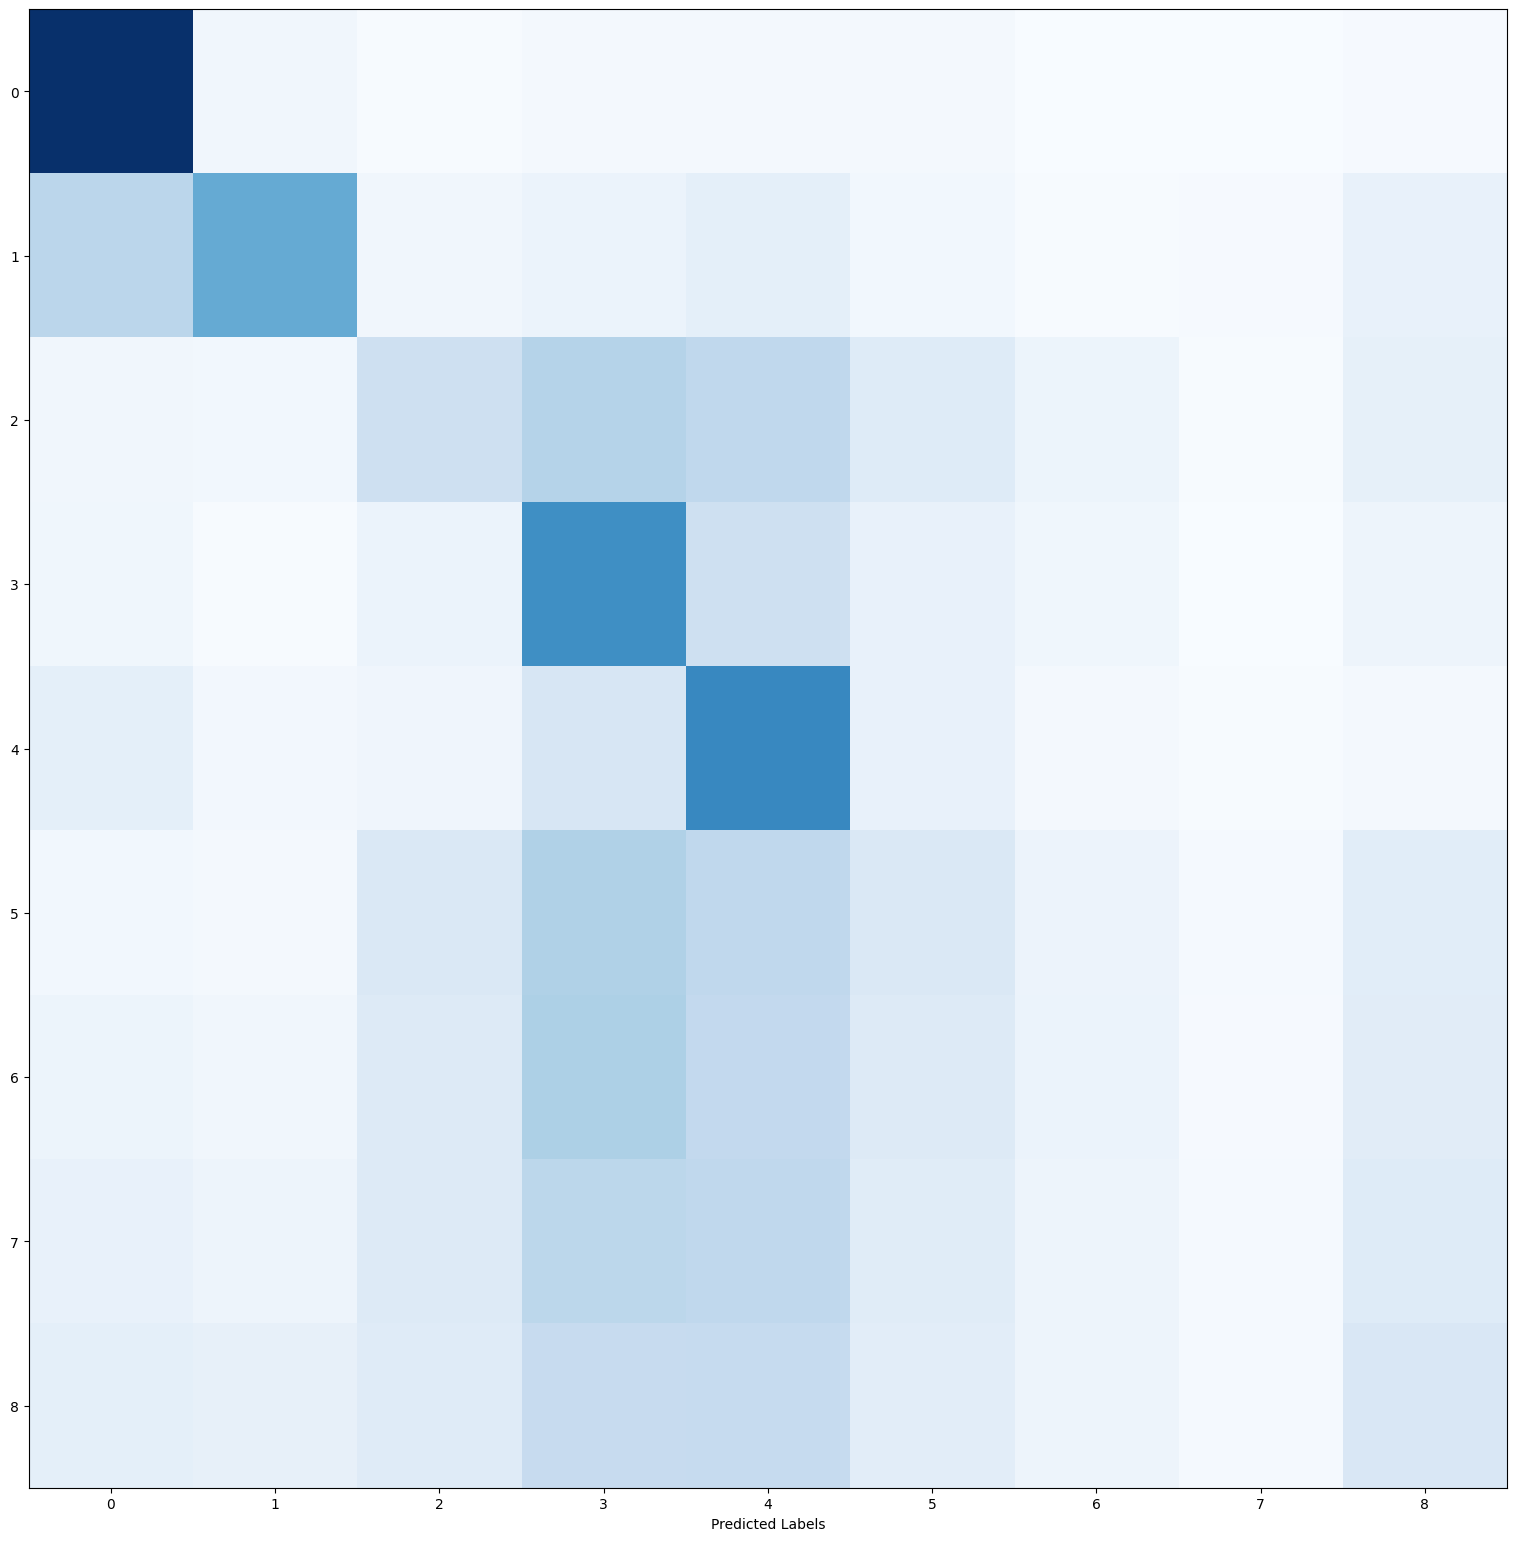

In [5]:
classifier_ensemble = []

for _ in range(5):
    # Create a new classifier
    classifier = Model(2, out_features=len(models), hidden_features=128, num_blocks=4, bias=True,spectral=False)
    classifier = classifier.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
    scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=2, max_epochs=10)
    # Set the classifier to training mode
    classifier.train()

    # Iterate over the batches in the dataloader
    for i in range(10):
        for inputs, labels in dataloader:
            scheduler.step()
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = classifier(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

    # Add the trained classifier to the ensemble
    classifier_ensemble.append(classifier)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
classifier_ensemble=[classifier.eval() for classifier in classifier_ensemble]
# Assuming classifier, inputs_, and labels_ are already defined and are lists of tensors
with torch.no_grad():
    inputs = dataloader.dataset.tensors[0].to(device).cpu()
    labels = dataloader.dataset.tensors[1].to(device).cpu()


    outputs = [classifier.cpu()(inputs).unsqueeze(-1) for classifier in classifier_ensemble]
    outputs = torch.cat(outputs, dim=-1).mean(dim=-1)

    # Get the predicted labels
    _, predicted = torch.max(outputs, 1)

# Calculate the confusion matrix
cm = confusion_matrix(labels.numpy(), predicted.numpy())
plt.figure(figsize=(6.4*3, 6.4*3))
# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predicted Labels',fontsize=20*3)
plt.ylabel('True Labels',fontsize=20*3)

# Adding text annotations in the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]/cm.sum(1)[i], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontdict={"size":30})
plt.xticks(np.arange(len(names)), names, rotation=90,fontsize=15*3)
plt.yticks(np.arange(len(names)), names,fontsize=15*3)

os.makedirs("../gen_model_playground/plots/eval",exist_ok=True)
plt.tight_layout()

plt.savefig("../gen_model_playground/plots/eval/confusion_matrix_all.pdf")
plt.show()

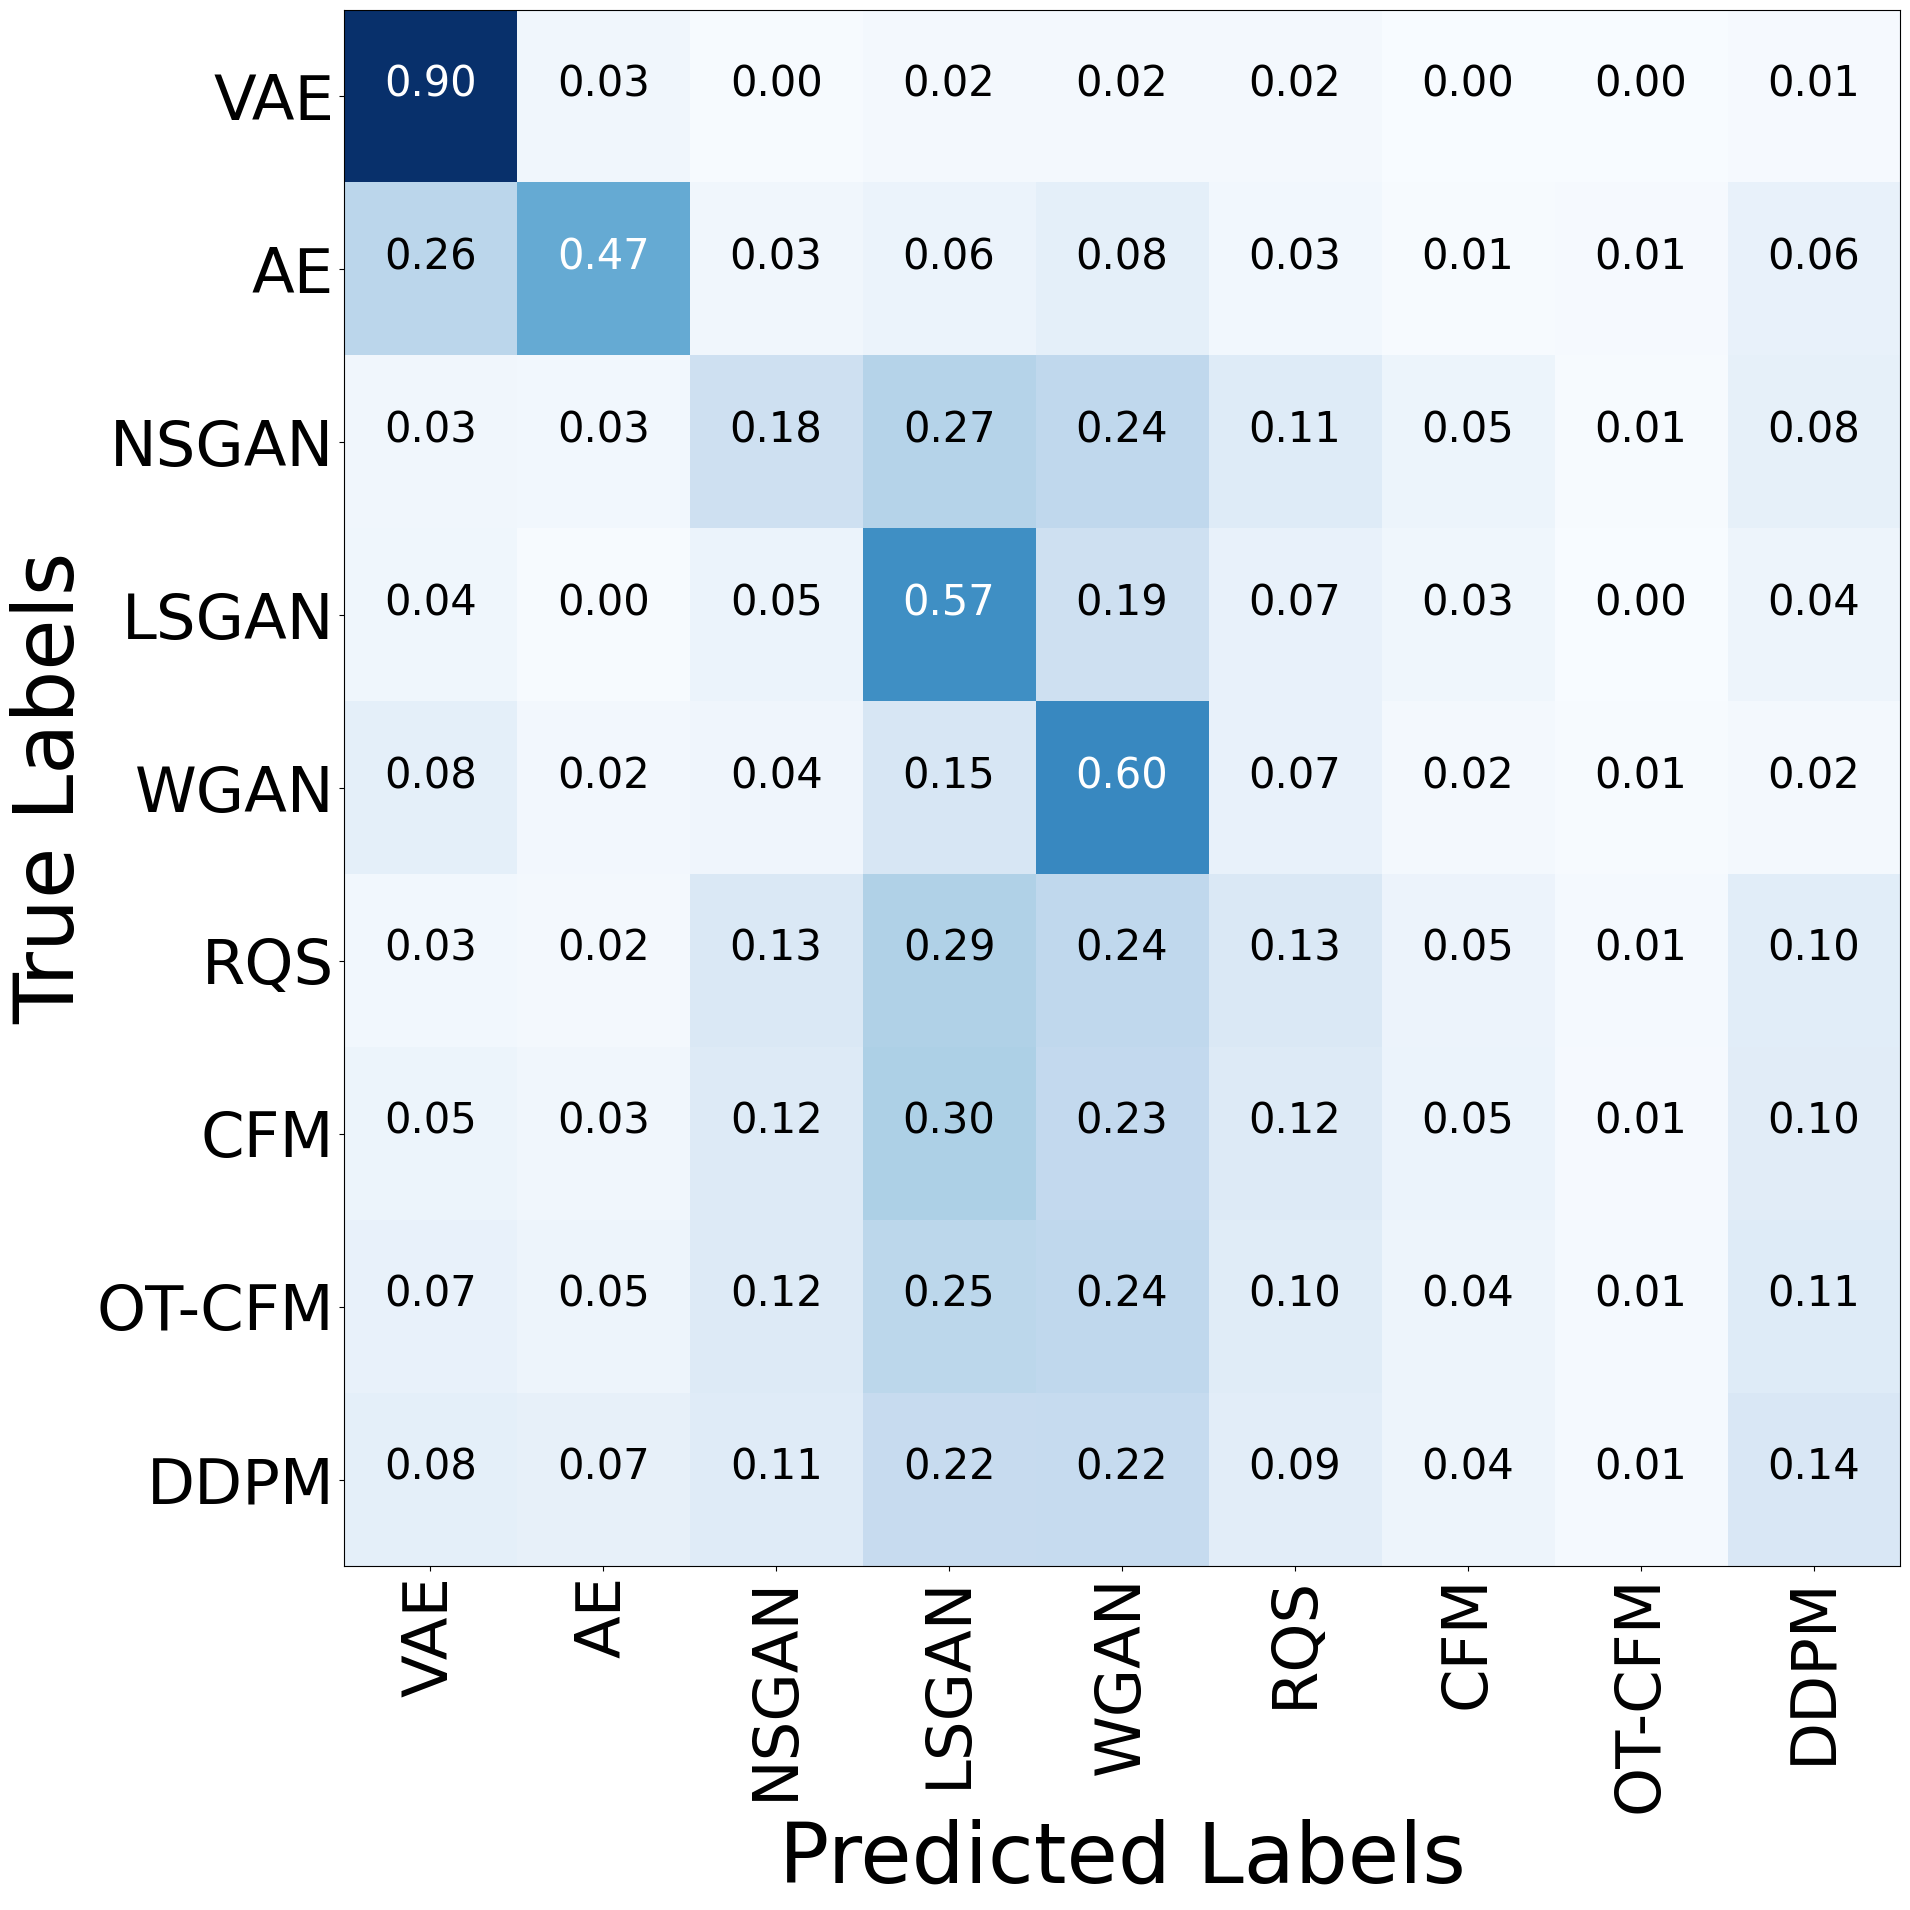

/tmp/ipykernel_21680/863709767.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted = torch.nn.functional.softmax(outputs).mean(0)


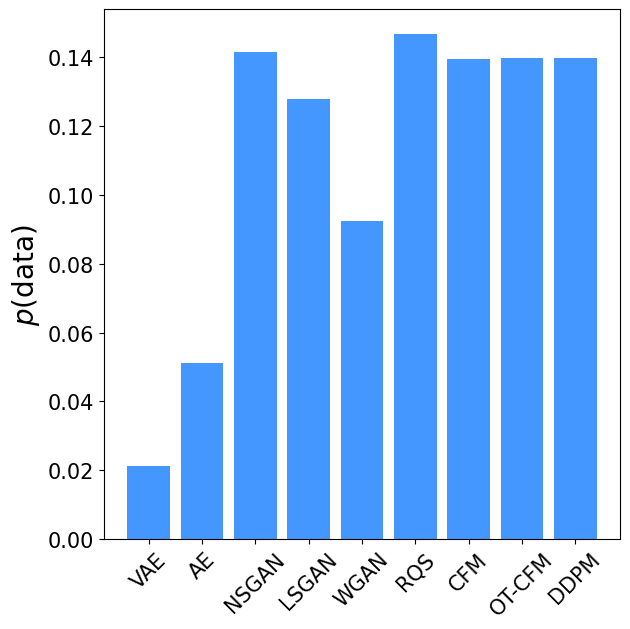

In [ ]:
with torch.no_grad():
    dm=TwoMoonsDataModule(1000,100)
    dm.setup()
    x,y=dm.train_dataloader().dataset.tensors

    # Get the predicted labels
    plt.figure(figsize=(6.4,6.4))
    outputs = [classifier.cpu()(x).unsqueeze(-1) for classifier in classifier_ensemble]
    outputs = torch.cat(outputs, dim=-1).mean(dim=-1)
    predicted = torch.nn.functional.softmax(outputs).mean(0)

    plt.ylabel(r"$p(\rm data)$",fontsize=20)
    plt.bar(np.arange(len(names)),predicted.cpu().numpy())
    plt.xticks(np.arange(len(names)), labels=names, rotation=45)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig("../gen_model_playground/plots/eval/predicted_all.pdf")
    plt.show()



# Limited Comparison

In [9]:
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
names=["RQS","AE","VAE","WGAN"]
models=[flow,ae,vae,wgan]
names=["AE","RQS","NSGAN"]
models=[ae,flow,nsgan]
device="cuda" if torch.cuda.is_available() else "cpu"
data_dict={}
cmap = LinearSegmentedColormap.from_list("", ["white", *plt.cm.Blues(np.arange(255))])

lims=[[ae.hparams.scaled_min[0]*1.1,ae.hparams.scaled_max[0]*1.1]
        ,[ae.hparams.scaled_min[1]*1.1,ae.hparams.scaled_max[1]*1.1]]
import torch
from torch.utils.data import TensorDataset, DataLoader
with torch.no_grad():

    for model,name in zip(models,names[:len(models)]):

        model=model.to(device)
        model.eval()
        z=torch.randn(10000, model.hparams.in_features).to(device)
        if name!="ddpm":
            xhat=model.sample(z)
        else:
            xhat,ddpm.traj = ddpm.sample(z,cond=None,return_traj=True)
        data_dict[name]=xhat.cpu()
# Convert the dictionary into tensors
class_tensors = [torch.tensor(data_dict[key]) for key in data_dict.keys()]

# Create a list of labels corresponding to each class
labels = [torch.full((len(class_tensors[i]),), i) for i in range(len(class_tensors))]

# Concatenate the tensors and labels
data = torch.cat(class_tensors)
target = torch.cat(labels)

# Create a TensorDataset
dataset = TensorDataset(data, target)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

classifier_ensemble = []

for _ in range(5):
    # Create a new classifier
    classifier = Model(2, out_features=len(models), hidden_features=32, num_blocks=4, bias=True,spectral=False)
    classifier = classifier.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
    scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=2, max_epochs=10)
    # Set the classifier to training mode
    classifier.train()

    # Iterate over the batches in the dataloader
    for i in range(10):
        for inputs, labels in dataloader:
            scheduler.step()
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = classifier(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

    # Add the trained classifier to the ensemble
    classifier_ensemble.append(classifier)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch


/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/tmp/ipykernel_26124/998384876.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_tensors = [torch.tensor(data_dict[key]) for key in data_dict.keys()]
/tmp/ipykernel_26124/998384876.py:52: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=2, max_epochs=10)

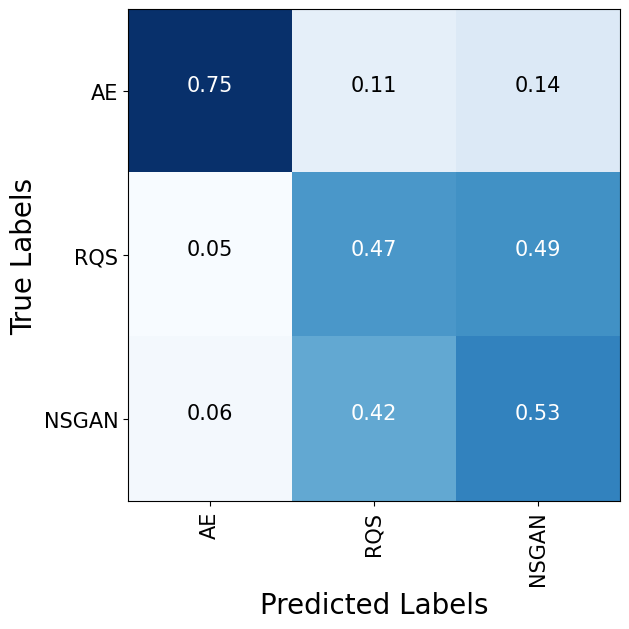

In [12]:
classifier_ensemble=[classifier.eval() for classifier in classifier_ensemble]
# Assuming classifier, inputs_, and labels_ are already defined and are lists of tensors
with torch.no_grad():
    inputs = dataloader.dataset.tensors[0].to(device).cpu()
    labels = dataloader.dataset.tensors[1].to(device).cpu()


    outputs = [classifier.cpu()(inputs).unsqueeze(-1) for classifier in classifier_ensemble]
    outputs = torch.cat(outputs, dim=-1).mean(dim=-1)

    # Get the predicted labels
    _, predicted = torch.max(outputs, 1)

# Calculate the confusion matrix
cm = confusion_matrix(labels.numpy(), predicted.numpy())
plt.figure(figsize=(6.4,6.4))
# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predicted Labels',fontsize=20)
plt.ylabel('True Labels',fontsize=20)

# Adding text annotations in the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]/cm.sum(1)[i], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontdict={"size":15})
plt.xticks(np.arange(len(names)), names, rotation=90,fontsize=15)
plt.yticks(np.arange(len(names)), names, fontsize=15)

os.makedirs("../gen_model_playground/plots/eval",exist_ok=True)
plt.tight_layout()

plt.savefig("../gen_model_playground/plots/eval/confusion_matrix.pdf")
plt.show()

/tmp/ipykernel_26124/921503700.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted = torch.nn.functional.softmax(outputs).mean(0)


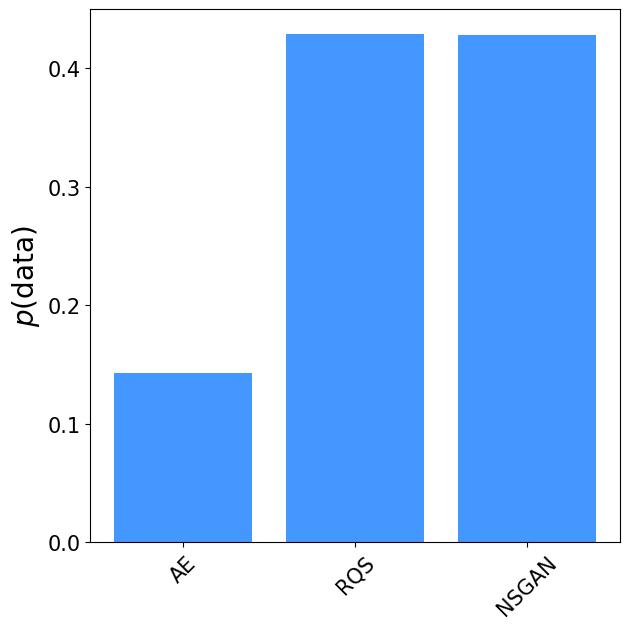

In [11]:
with torch.no_grad():
    dm=TwoMoonsDataModule(1000,100)
    dm.setup()
    x,y=dm.train_dataloader().dataset.tensors
    classifier.eval()
    outputs = [classifier.cpu()(x).unsqueeze(-1) for classifier in classifier_ensemble]
    outputs = torch.cat(outputs, dim=-1).mean(dim=-1)
    # Get the predicted labels
    plt.figure(figsize=(6.4,6.4))
    predicted = torch.nn.functional.softmax(outputs).mean(0)

    plt.bar(np.arange(len(names)),predicted.cpu().numpy())
    # _,bins,_=plt.hist(predicted.cpu().numpy(),bins=len(names),density=True)
    plt.ylabel(r"$p(\rm data)$",fontsize=20)
    plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=45)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig("../gen_model_playground/plots/eval/predicted.pdf")
    plt.show()
